# Telco Churn Prediction

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Settings
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Task 1: 
Exploratory Data Analysis.

Step 1: Examine the overall picture.

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

In [3]:
def check_df(dataframe, head=7, tail=7):
    '''
    Prints the general information about the given dataframe e.g. shape, head,
    tail, info, descriptive statistics, etc.

    Parameters
    ----------
    dataframe : DataFrame
        The dataframe that we want to have general information about.
    head: int
        Prints the first n rows of the dataframe.
    tail: int
        Prints the last n rows of the dataframe.
    '''
    print('####### Shape #######')
    print(dataframe.shape)
    print('####### Info #######')
    print(dataframe.info())
    print('####### Head #######')
    print(dataframe.head(head))
    print('####### Tail #######')
    print(dataframe.tail(tail))
    print('####### Descriptive Statistics #######')
    print(dataframe.describe([0.05, 0.25, 0.50, 0.75 ,0.95, 0.99]).T)
    print('####### NA #######')
    print(dataframe.isnull().sum())
    print('####### Number of Unique Values #######')
    print(dataframe.nunique())


check_df(df)

####### Shape #######
(7043, 21)
####### Info #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   o

In [4]:
# 'TotalCharges' must be numeric variable
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [5]:
# 'Churn' unique values are 'No', 'Yes'
# Converting 'Churn' variable values 'Yes' to 1 and 'No' to 0
df['Churn'] = df['Churn'].apply(lambda x : 1 if x == 'Yes' else 0)

Step 2: Capture the numeric and categorical variables.

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    '''
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included.
    
    Parameters
    ----------
    dataframe : DataFrame
        The dataframe containing the data.
    cat_th : int, optional
        Class threshold value for variables that appear numerical but are categorical.
    car_th : int, optional
        Class threshold value for variables that appear categorical but are cardinal.

    Returns
    -------
    cat_cols: list
        Categorical variable list.
    num_cols: list
        Numerical variable list.
    cat_but_car: list
        List of cardinal variables appearing categorical.

    Notes
    -----
    Total number of variables: cat_cols + num_cols + cat_but_car
    num_but_cat inside cat_cols
    '''
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Report
    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [7]:
print('Categorical Variables:', cat_cols, 
      '\nNumerical Variables:', num_cols, 
      '\nCategorical but Cardinal Variables:', cat_but_car)

Categorical Variables: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn'] 
Numerical Variables: ['tenure', 'MonthlyCharges', 'TotalCharges'] 
Categorical but Cardinal Variables: ['customerID']


Step 3: Analyze the numerical and categorical variables.

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


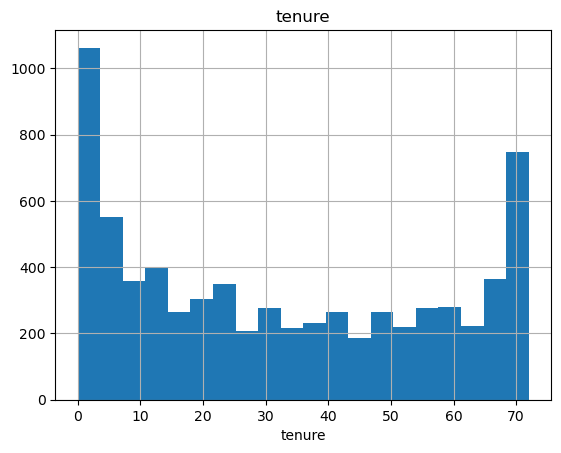

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


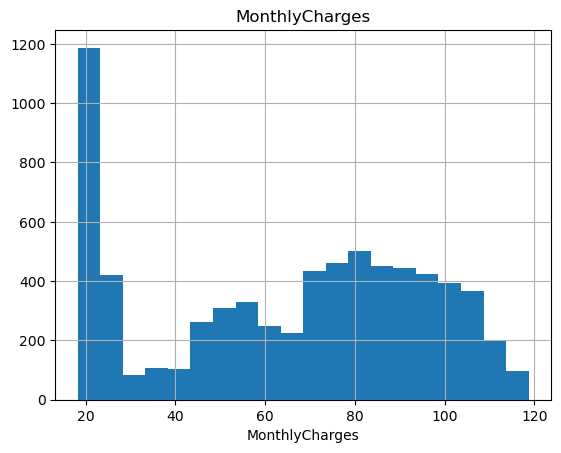

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


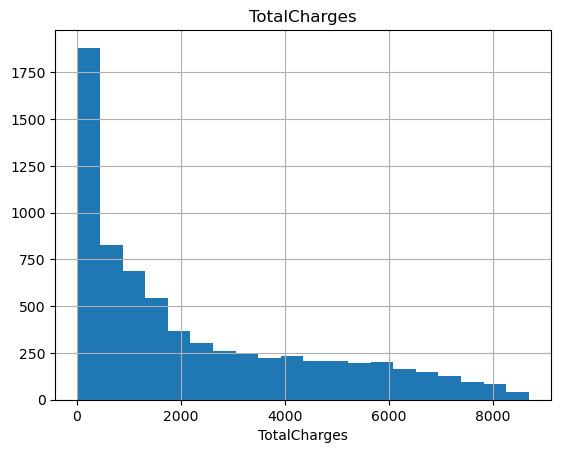

In [8]:
# Numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


for col in num_cols:
    num_summary(df, col, plot=True)

In [9]:
# Categorical variables
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print('##########################################')

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col, plot=False)

        gender  Ratio
Male      3555 50.476
Female    3488 49.524
##########################################
     Partner  Ratio
No      3641 51.697
Yes     3402 48.303
##########################################
     Dependents  Ratio
No         4933 70.041
Yes        2110 29.959
##########################################
     PhoneService  Ratio
Yes          6361 90.317
No            682  9.683
##########################################
                  MultipleLines  Ratio
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################
             InternetService  Ratio
Fiber optic             3096 43.959
DSL                     2421 34.375
No                      1526 21.667
##########################################
                     OnlineSecurity  Ratio
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667


Step 4: Perform target variable analysis (The mean of the target variable according to the categorical variables, the mean of the numeric variables according to the target variable).

   Churn  Ratio
0   5174 73.463
1   1869 26.537


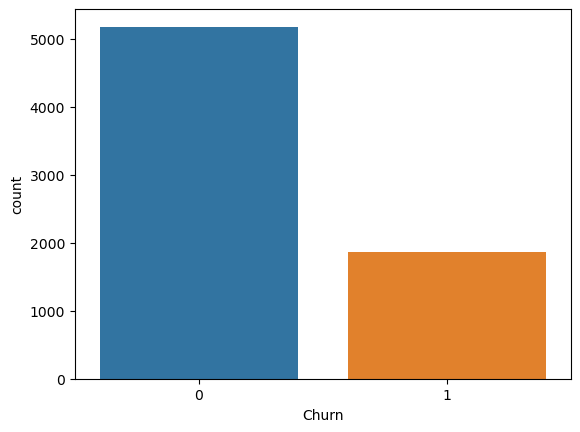

In [10]:
# Target variable
print(pd.DataFrame({'Churn': df['Churn'].value_counts(), 
                    'Ratio': 100 * df['Churn'].value_counts() / len(df)}))

sns.countplot(x='Churn', data=df)
plt.show()

In [11]:
# Analysis of numerical variables according to target variable
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: 'mean'}), end='\n\n\n')


for col in num_cols:
    target_summary_with_num(df, 'Churn', col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




In [12]:
# Analysis of categorical variables according to target variable
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({
        'COUNT': dataframe[categorical_col].value_counts(), 
        'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean(), 
        'RATIO': 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end='\n\n\n')


for col in cat_cols:
    target_summary_with_cat(df, 'Churn', col)

gender
        COUNT  TARGET_MEAN  RATIO
Female   3488        0.269 49.524
Male     3555        0.262 50.476


Partner
     COUNT  TARGET_MEAN  RATIO
No    3641        0.330 51.697
Yes   3402        0.197 48.303


Dependents
     COUNT  TARGET_MEAN  RATIO
No    4933        0.313 70.041
Yes   2110        0.155 29.959


PhoneService
     COUNT  TARGET_MEAN  RATIO
No     682        0.249  9.683
Yes   6361        0.267 90.317


MultipleLines
                  COUNT  TARGET_MEAN  RATIO
No                 3390        0.250 48.133
No phone service    682        0.249  9.683
Yes                2971        0.286 42.184


InternetService
             COUNT  TARGET_MEAN  RATIO
DSL           2421        0.190 34.375
Fiber optic   3096        0.419 43.959
No            1526        0.074 21.667


OnlineSecurity
                     COUNT  TARGET_MEAN  RATIO
No                    3498        0.418 49.666
No internet service   1526        0.074 21.667
Yes                   2019        0.146 28.667


O

Step 5: Analyze outliers.

In [13]:
# Outlier thresholds
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [14]:
# Check outlier
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


Step 6: Perform missing observation analysis.

In [15]:
# Variables with missing values
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')

    if na_name:
        return na_columns


na_cols = missing_values_table(df, True)

              n_miss  ratio
TotalCharges      11  0.160


In [16]:
# Relationship of missing values with the target variable
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains('_NA_')].columns
    for col in na_flags:
        print(pd.DataFrame({
            'COUNT': temp_df.groupby(col)[target].count(),
            'TARGET_MEAN': temp_df.groupby(col)[target].mean()}), end='\n\n\n')


missing_vs_target(df, 'Churn', na_cols)

                      COUNT  TARGET_MEAN
TotalCharges_NA_FLAG                    
0                      7032        0.266
1                        11        0.000




Step 7: Perform correlation analysis.

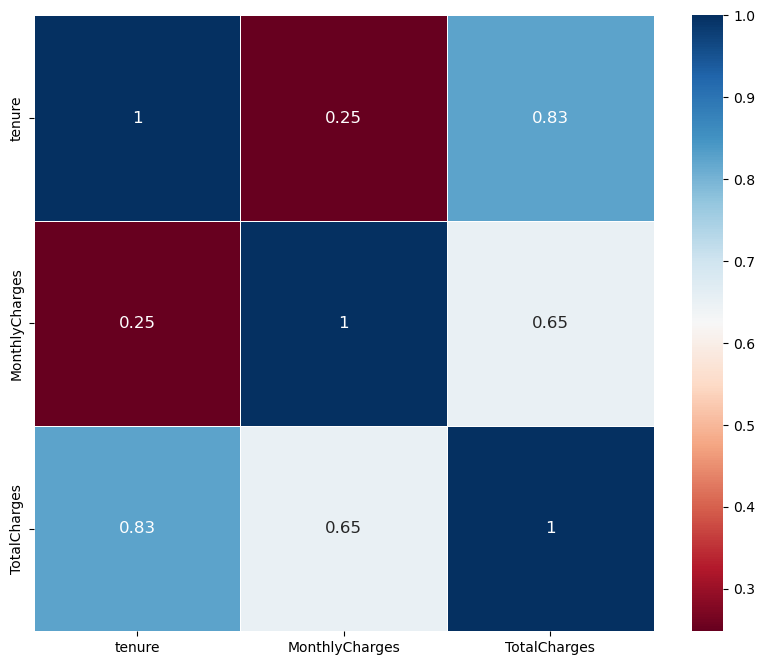

In [17]:
# Numerical variables correlation
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

    
correlation_matrix(df, num_cols)

In [18]:
# Target variable correlation with numerical variables
df[num_cols].corrwith(df['Churn']).sort_values(ascending=False)

MonthlyCharges    0.193
TotalCharges     -0.199
tenure           -0.352
dtype: float64

# Task 2: 
Feature Engineering.

Step 1: Take necessary actions for missing and outlier values.

- Outliers

In [19]:
# Check outlier
for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


- Missing Values

In [20]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [21]:
na_cols = missing_values_table(df, True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [22]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Base Model

In [23]:
df_base = df.copy()

In [24]:
cat_cols = [col for col in cat_cols if col not in ['Churn']]
len(cat_cols)

16

In [25]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


df_base = one_hot_encoder(df_base, cat_cols, drop_first=True)

In [26]:
y = df_base['Churn']
X = df_base.drop(['Churn', 'customerID'], axis=1)

In [27]:
models = [('LR', LogisticRegression(random_state=42)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('SVM', SVC(gamma='auto', random_state=42)),
          ('XGBoost', XGBClassifier(use_label_encoder=False, random_state=42)),
          ('LightGBM', LGBMClassifier(random_state=42)),
          ('CatBoost', CatBoostClassifier(verbose=False, random_state=42))
          ]

In [28]:
scoring = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

for score in scoring:
    print(f'{score}:')
    for name, model in models:
        cv_results = cross_validate(model, X, y, cv=10, scoring=score)
        print(f"\t{cv_results['test_score'].mean():.3f} ({name})")
    print()

accuracy:
	0.803 (LR)
	0.764 (KNN)
	0.727 (CART)
	0.792 (RF)
	0.770 (SVM)
	0.783 (XGBoost)
	0.797 (LightGBM)
	0.798 (CatBoost)

roc_auc:
	0.843 (LR)
	0.746 (KNN)
	0.659 (CART)
	0.826 (RF)
	0.714 (SVM)
	0.824 (XGBoost)
	0.836 (LightGBM)
	0.841 (CatBoost)

f1:
	0.592 (LR)
	0.501 (KNN)
	0.498 (CART)
	0.553 (RF)
	0.401 (SVM)
	0.551 (XGBoost)
	0.581 (LightGBM)
	0.573 (CatBoost)

recall:
	0.541 (LR)
	0.447 (KNN)
	0.511 (CART)
	0.485 (RF)
	0.291 (SVM)
	0.502 (XGBoost)
	0.530 (LightGBM)
	0.510 (CatBoost)

precision:
	0.655 (LR)
	0.572 (KNN)
	0.487 (CART)
	0.643 (RF)
	0.649 (SVM)
	0.613 (XGBoost)
	0.644 (LightGBM)
	0.653 (CatBoost)



Step 2: Create new variables.

In [29]:
# Dependents (Yes, No) & SeniorCitizen (1: Old, 0: Young) & Gender (Female, Male)
df.loc[(df['Dependents'] == 'Yes') & (df['SeniorCitizen'] == 0) & (df['gender'] == 'Female'), 'CITIZEN_STATUS'] = 'dependent_young_female'
df.loc[(df['Dependents'] == 'Yes') & (df['SeniorCitizen'] == 0) & (df['gender'] == 'Male'), 'CITIZEN_STATUS'] = 'dependent_young_male'
df.loc[(df['Dependents'] == 'No') & (df['SeniorCitizen'] == 0) & (df['gender'] == 'Female'), 'CITIZEN_STATUS'] = 'independent_young_female'
df.loc[(df['Dependents'] == 'No') & (df['SeniorCitizen'] == 0) & (df['gender'] == 'Male'), 'CITIZEN_STATUS'] = 'independent_young_male'
df.loc[(df['Dependents'] == 'Yes') & (df['SeniorCitizen'] == 1) & (df['gender'] == 'Female'), 'CITIZEN_STATUS'] = 'dependent_senior_female'
df.loc[(df['Dependents'] == 'Yes') & (df['SeniorCitizen'] == 1) & (df['gender'] == 'Male'), 'CITIZEN_STATUS'] = 'dependent_senior_male'
df.loc[(df['Dependents'] == 'No') & (df['SeniorCitizen'] == 1) & (df['gender'] == 'Female'), 'CITIZEN_STATUS'] = 'independent_senior_female'
df.loc[(df['Dependents'] == 'No') & (df['SeniorCitizen'] == 1) & (df['gender'] == 'Male'), 'CITIZEN_STATUS'] = 'independent_senior_male'

In [30]:
# Generating annual categorical variable from 'Tenure' variable
df.loc[(df['tenure'] >= 0) & (df['tenure'] <= 12), 'NEW_TENURE_YEAR'] = '0_1_year'
df.loc[(df['tenure'] > 12) & (df['tenure'] <= 24), 'NEW_TENURE_YEAR'] = '1_2_year'
df.loc[(df['tenure'] > 24) & (df['tenure'] <= 36), 'NEW_TENURE_YEAR'] = '2_3_year'
df.loc[(df['tenure'] > 36) & (df['tenure'] <= 48), 'NEW_TENURE_YEAR'] = '3_4_year'
df.loc[(df['tenure'] > 48) & (df['tenure'] <= 60), 'NEW_TENURE_YEAR'] = '4_5_year'
df.loc[(df['tenure'] > 60) & (df['tenure'] <= 72), 'NEW_TENURE_YEAR'] = '5_6_year'

In [31]:
# Specify contract 1 or 2 year customers as Engaged
df['NEW_ENGAGED'] = df['Contract'].apply(lambda x: 1 if x in ['One year', 'Two year'] else 0)

In [32]:
# People who do not receive any support, backup or protection
df['NEW_NO_PROT'] = df.apply(lambda x: 1 if (x['OnlineBackup'] != 'Yes') or (x['DeviceProtection'] != 'Yes') or (x['TechSupport'] != 'Yes') else 0, axis=1)

In [33]:
# Young customers with monthly contracts
df['NEW_YOUNG_NOT_ENGAGED'] = df.apply(lambda x: 1 if (x['NEW_ENGAGED'] == 0) and (x['SeniorCitizen'] == 0) else 0, axis=1)

In [34]:
# The total number of services received by the person
df['NEW_TOTALSERVICES'] = (df[['PhoneService', 'InternetService', 
                               'OnlineSecurity', 'OnlineBackup', 
                               'DeviceProtection', 'TechSupport', 
                               'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

In [35]:
# People who buy any streaming service
df['NEW_FLAG_ANY_STREAMING'] = df.apply(lambda x: 1 if (x['StreamingTV'] == 'Yes') or (x['StreamingMovies'] == 'Yes') else 0, axis=1)

In [36]:
# Does the person make automatic payments?
df['NEW_FLAG_AUTOPAYMENT'] = df['PaymentMethod'].apply(lambda x: 1 if x in ['Bank transfer (automatic)', 'Credit card (automatic)'] else 0)

In [37]:
# Average monthly payment
df['NEW_AVG_CHARGES'] = df['TotalCharges'] / (df['tenure'] + 1)

In [38]:
# Current Price increase relative to average price
df['NEW_INCREASE'] = df['NEW_AVG_CHARGES'] / df['MonthlyCharges']

In [39]:
# Fee per service
df['NEW_AVG_SERVICE_FEE'] = df['MonthlyCharges'] / (df['NEW_TOTALSERVICES'] + 1)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customerID              7043 non-null   object 
 1   gender                  7043 non-null   object 
 2   SeniorCitizen           7043 non-null   int64  
 3   Partner                 7043 non-null   object 
 4   Dependents              7043 non-null   object 
 5   tenure                  7043 non-null   int64  
 6   PhoneService            7043 non-null   object 
 7   MultipleLines           7043 non-null   object 
 8   InternetService         7043 non-null   object 
 9   OnlineSecurity          7043 non-null   object 
 10  OnlineBackup            7043 non-null   object 
 11  DeviceProtection        7043 non-null   object 
 12  TechSupport             7043 non-null   object 
 13  StreamingTV             7043 non-null   object 
 14  StreamingMovies         7043 non-null   

Step 3: Perform the encoding operations.

In [41]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 32
cat_cols: 25
num_cols: 6
cat_but_car: 1
num_but_cat: 8


- Label Encoding

In [42]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [43]:
binary_cols = [col for col in df.columns if df[col].dtypes == 'O' and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [44]:
for col in binary_cols:
    label_encoder(df, col)

In [45]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,CITIZEN_STATUS,NEW_TENURE_YEAR,NEW_ENGAGED,NEW_NO_PROT,NEW_YOUNG_NOT_ENGAGED,NEW_TOTALSERVICES,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AUTOPAYMENT,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,independent_young_female,0_1_year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,independent_young_male,2_3_year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,independent_young_male,0_1_year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,independent_young_male,3_4_year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,independent_young_female,0_1_year,0,1,1,1,0,0,50.550,0.715,35.350


- One-Hot Encoding

In [46]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ['Churn', 'NEW_TOTALSERVICES']]
len(cat_cols)

18

In [47]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


df = one_hot_encoder(df, cat_cols, drop_first=True)

In [48]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TOTALSERVICES,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,CITIZEN_STATUS_dependent_senior_male,CITIZEN_STATUS_dependent_young_female,CITIZEN_STATUS_dependent_young_male,CITIZEN_STATUS_independent_senior_female,CITIZEN_STATUS_independent_senior_male,CITIZEN_STATUS_independent_young_female,CITIZEN_STATUS_independent_young_male,NEW_TENURE_YEAR_1_2_year,NEW_TENURE_YEAR_2_3_year,NEW_TENURE_YEAR_3_4_year,NEW_TENURE_YEAR_4_5_year,NEW_TENURE_YEAR_5_6_year,SeniorCitizen_1,NEW_ENGAGED_1,NEW_NO_PROT_1,NEW_YOUNG_NOT_ENGAGED_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AUTOPAYMENT_1
0,7590-VHVEG,0,1,0,1,0,1,29.850,29.850,0,1,14.925,0.500,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
1,5575-GNVDE,1,0,0,34,1,0,56.950,1889.500,0,3,53.986,0.948,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
2,3668-QPYBK,1,0,0,2,1,1,53.850,108.150,1,3,36.050,0.669,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,1,0,0,45,0,0,42.300,1840.750,0,3,40.016,0.946,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1
4,9237-HQITU,0,0,0,2,1,1,70.700,151.650,1,1,50.550,0.715,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0


# Task 3:
Modelling.

Step 1: Build models with classification algorithms.

In [49]:
y = df['Churn']
X = df.drop(['Churn', 'customerID'], axis=1)

In [50]:
models = [('LR', LogisticRegression(random_state=42)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('SVM', SVC(gamma='auto', random_state=42)),
          ('XGBoost', XGBClassifier(use_label_encoder=False, random_state=42)),
          ('LightGBM', LGBMClassifier(random_state=42)),
          ('CatBoost', CatBoostClassifier(verbose=False, random_state=42))
          ]

In [51]:
scoring = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

for score in scoring:
    print(f'{score}:')
    for name, model in models:
        cv_results = cross_validate(model, X, y, cv=10, scoring=score)
        print(f"\t{cv_results['test_score'].mean():.3f} ({name})")
    print()

accuracy:
	0.806 (LR)
	0.771 (KNN)
	0.726 (CART)
	0.795 (RF)
	0.768 (SVM)
	0.786 (XGBoost)
	0.795 (LightGBM)
	0.800 (CatBoost)

roc_auc:
	0.843 (LR)
	0.754 (KNN)
	0.655 (CART)
	0.826 (RF)
	0.728 (SVM)
	0.826 (XGBoost)
	0.834 (LightGBM)
	0.843 (CatBoost)

f1:
	0.585 (LR)
	0.518 (KNN)
	0.492 (CART)
	0.567 (RF)
	0.378 (SVM)
	0.559 (XGBoost)
	0.575 (LightGBM)
	0.581 (CatBoost)

recall:
	0.517 (LR)
	0.464 (KNN)
	0.501 (CART)
	0.504 (RF)
	0.267 (SVM)
	0.511 (XGBoost)
	0.522 (LightGBM)
	0.522 (CatBoost)

precision:
	0.675 (LR)
	0.587 (KNN)
	0.484 (CART)
	0.648 (RF)
	0.653 (SVM)
	0.617 (XGBoost)
	0.640 (LightGBM)
	0.654 (CatBoost)



Step 2: Perform hyperparameter optimization with the models you selected and rebuild the model with the hyperparameters you found.

- Random Forests

In [52]:
rf_model = RandomForestClassifier(random_state=42)

In [53]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [54]:
rf_params = {'max_depth': [5, 8, 10, None],
             'max_features': [3, 5, 7, 'auto'],
             'min_samples_split': [2, 5, 10, 15, 20],
             'n_estimators': [100, 200, 400, 500]}

In [55]:
rf_best_grid = GridSearchCV(rf_model, 
                            rf_params, 
                            cv=5, 
                            n_jobs=-1, 
                            verbose=True).fit(X, y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [56]:
rf_best_grid.best_params_

{'max_depth': 10,
 'max_features': 3,
 'min_samples_split': 10,
 'n_estimators': 400}

In [57]:
rf_best_grid.best_score_

0.8012221554616428

In [58]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=42).fit(X, y)

In [59]:
scoring = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

cv_results = cross_validate(rf_final, X, y, cv=10, scoring=scoring)

for score in scoring:
    mean_score = np.mean(cv_results[f'test_{score}'])
    print(f'{score}: {mean_score:.3f}')

accuracy: 0.800
roc_auc: 0.845
f1: 0.563
recall: 0.485
precision: 0.671


- XGBoost

In [60]:
xgboost_model = XGBClassifier(use_label_encoder=False, random_state=42)

In [61]:
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [62]:
xgboost_params = {'learning_rate': [0.1, 0.01, 0.001],
                  'max_depth': [5, 8, 12, 15, 20],
                  'n_estimators': [100, 500, 700, 1000],
                  'colsample_bytree': [0.5, 0.7, 1]}

In [63]:
xgboost_best_grid = GridSearchCV(xgboost_model, 
                                 xgboost_params, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [64]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 700}

In [65]:
xgboost_best_grid.best_score_

0.8024984474804826

In [66]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=42).fit(X, y)

In [67]:
scoring = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

cv_results = cross_validate(xgboost_final, X, y, cv=10, scoring=scoring)

for score in scoring:
    mean_score = np.mean(cv_results[f'test_{score}'])
    print(f'{score}: {mean_score:.3f}')

accuracy: 0.801
roc_auc: 0.845
f1: 0.578
recall: 0.515
precision: 0.661


- LightGBM

In [68]:
lgbm_model = LGBMClassifier(random_state=42)

In [69]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [70]:
lgbm_params = {'learning_rate': [0.01, 0.1, 0.001],
               'n_estimators': [100, 300, 500, 700, 1000],
               'colsample_bytree': [0.5, 0.7, 1]}

In [71]:
lgbm_best_grid = GridSearchCV(lgbm_model, 
                              lgbm_params, 
                              cv=5, 
                              n_jobs=-1, 
                              verbose=True).fit(X, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [72]:
lgbm_best_grid.best_params_

{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 500}

In [73]:
lgbm_best_grid.best_score_

0.803068343118911

In [74]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=42).fit(X, y)

In [75]:
scoring = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

cv_results = cross_validate(lgbm_final, X, y, cv=10, scoring=scoring)

for score in scoring:
    mean_score = np.mean(cv_results[f'test_{score}'])
    print(f'{score}: {mean_score:.3f}')

accuracy: 0.803
roc_auc: 0.845
f1: 0.587
recall: 0.527
precision: 0.662


- CatBoost

In [76]:
catboost_model = CatBoostClassifier(random_state=42, verbose=False)

In [77]:
catboost_params = {'iterations': [200, 400, 500],
                   'learning_rate': [0.01, 0.1],
                   'depth': [3, 6]}

In [78]:
catboost_best_grid = GridSearchCV(catboost_model, 
                                  catboost_params, 
                                  cv=5, 
                                  n_jobs=-1, 
                                  verbose=True).fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [79]:
catboost_best_grid.best_params_

{'depth': 3, 'iterations': 500, 'learning_rate': 0.01}

In [80]:
catboost_best_grid.best_score_

0.803350216142977

In [81]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=42).fit(X, y)

In [82]:
scoring = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

cv_results = cross_validate(catboost_final, X, y, cv=10, scoring=scoring)

for score in scoring:
    mean_score = np.mean(cv_results[f'test_{score}'])
    print(f'{score}: {mean_score:.3f}')

accuracy: 0.802
roc_auc: 0.847
f1: 0.568
recall: 0.491
precision: 0.675


In [83]:
# Feature importance
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values('Value',ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value',
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

Feature Importance for Random Forest:
    Value                                   Feature
11  0.096                       NEW_AVG_SERVICE_FEE
10  0.086                              NEW_INCREASE
3   0.084                                    tenure
7   0.077                              TotalCharges
46  0.077                             NEW_ENGAGED_1
9   0.054                           NEW_AVG_CHARGES
6   0.052                            MonthlyCharges
14  0.046               InternetService_Fiber optic
29  0.035                         Contract_Two year
31  0.034            PaymentMethod_Electronic check
48  0.022                   NEW_YOUNG_NOT_ENGAGED_1
17  0.019                        OnlineSecurity_Yes
8   0.018                         NEW_TOTALSERVICES
44  0.017                  NEW_TENURE_YEAR_5_6_year
50  0.017                    NEW_FLAG_AUTOPAYMENT_1
28  0.016                         Contract_One year
23  0.016                           TechSupport_Yes
5   0.015                 

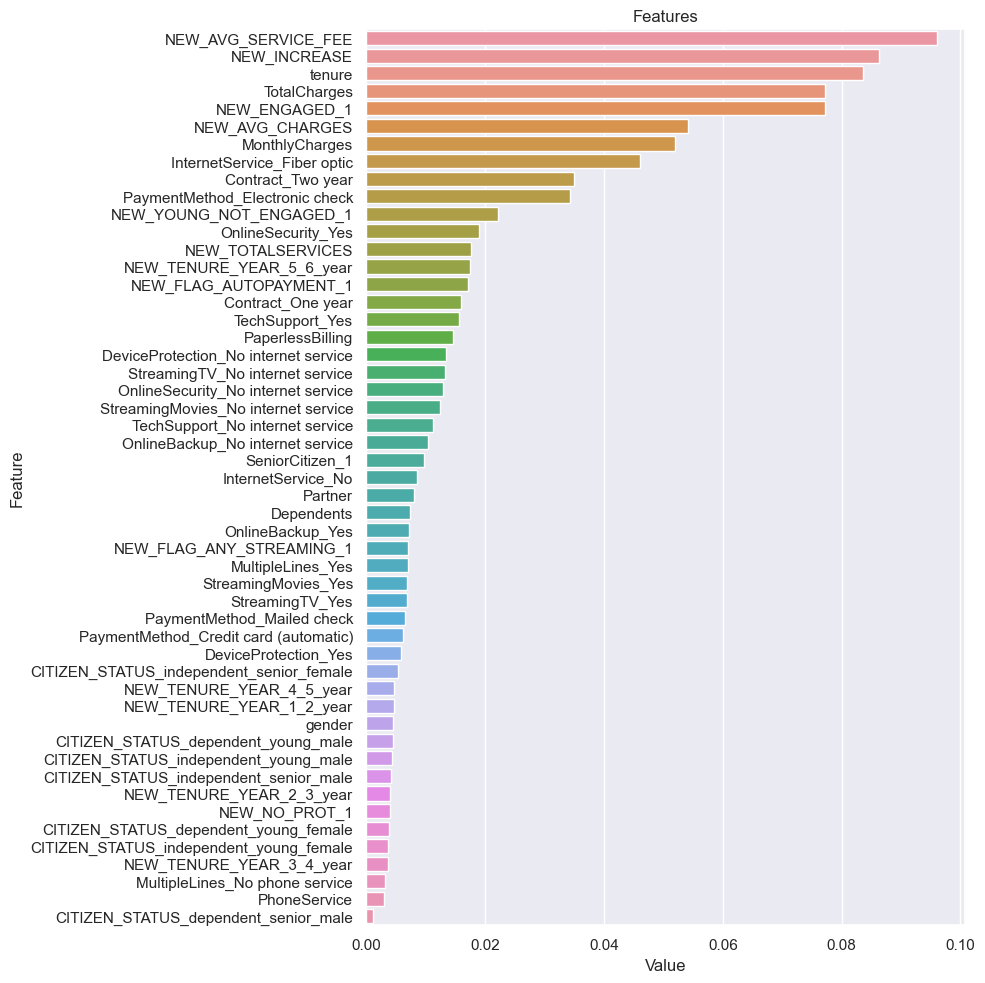

Feature Importance for XGBoost:
    Value                                   Feature
46  0.336                             NEW_ENGAGED_1
14  0.109               InternetService_Fiber optic
29  0.045                         Contract_Two year
15  0.039                        InternetService_No
22  0.036           TechSupport_No internet service
16  0.032        OnlineSecurity_No internet service
3   0.026                                    tenure
11  0.026                       NEW_AVG_SERVICE_FEE
31  0.025            PaymentMethod_Electronic check
28  0.018                         Contract_One year
18  0.017          OnlineBackup_No internet service
48  0.017                   NEW_YOUNG_NOT_ENGAGED_1
27  0.015                       StreamingMovies_Yes
44  0.013                  NEW_TENURE_YEAR_5_6_year
5   0.013                          PaperlessBilling
20  0.012      DeviceProtection_No internet service
49  0.011                  NEW_FLAG_ANY_STREAMING_1
13  0.011                       

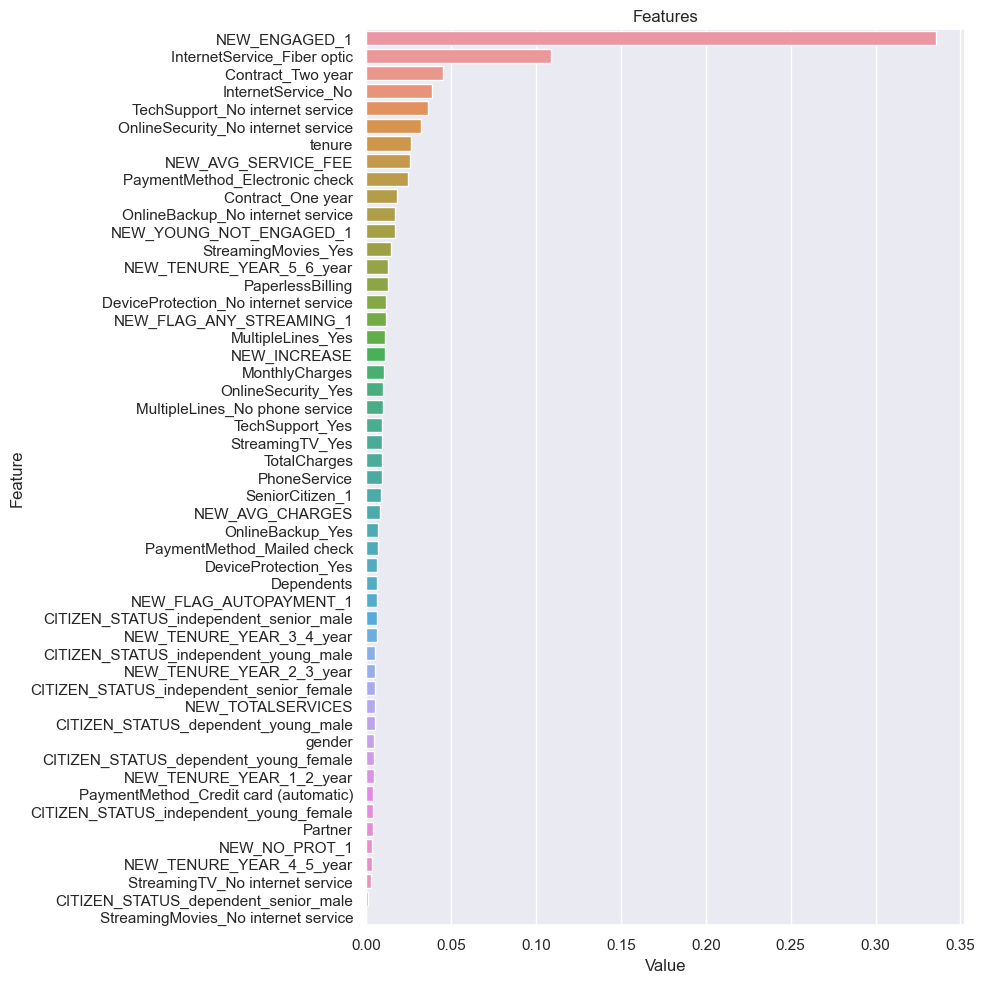

Feature Importance for LightGBM:
    Value                                   Feature
10   1859                              NEW_INCREASE
6    1747                            MonthlyCharges
7    1708                              TotalCharges
9    1621                           NEW_AVG_CHARGES
11   1618                       NEW_AVG_SERVICE_FEE
3    1491                                    tenure
5     307                          PaperlessBilling
31    264            PaymentMethod_Electronic check
27    230                       StreamingMovies_Yes
29    225                         Contract_Two year
17    218                        OnlineSecurity_Yes
8     197                         NEW_TOTALSERVICES
46    190                             NEW_ENGAGED_1
0     189                                    gender
13    186                         MultipleLines_Yes
25    184                           StreamingTV_Yes
28    181                         Contract_One year
23    167                      

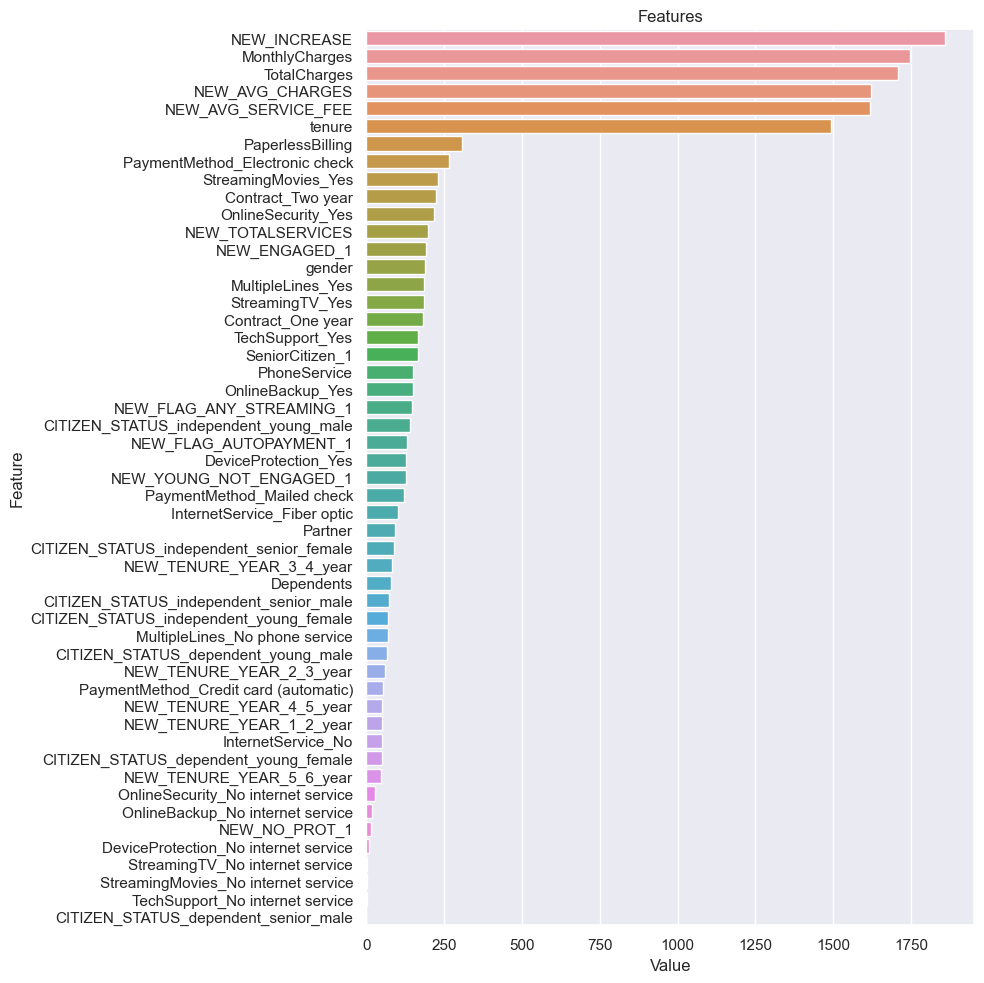

Feature Importance for CatBoost:
    Value                                   Feature
46 21.107                             NEW_ENGAGED_1
3  13.283                                    tenure
11 10.864                       NEW_AVG_SERVICE_FEE
14  9.631               InternetService_Fiber optic
29  8.739                         Contract_Two year
10  6.452                              NEW_INCREASE
31  3.816            PaymentMethod_Electronic check
7   3.061                              TotalCharges
6   2.583                            MonthlyCharges
5   2.105                          PaperlessBilling
44  1.971                  NEW_TENURE_YEAR_5_6_year
26  1.526       StreamingMovies_No internet service
27  1.464                       StreamingMovies_Yes
9   1.375                           NEW_AVG_CHARGES
25  1.312                           StreamingTV_Yes
16  1.233        OnlineSecurity_No internet service
49  1.208                  NEW_FLAG_ANY_STREAMING_1
20  1.158      DeviceProtection

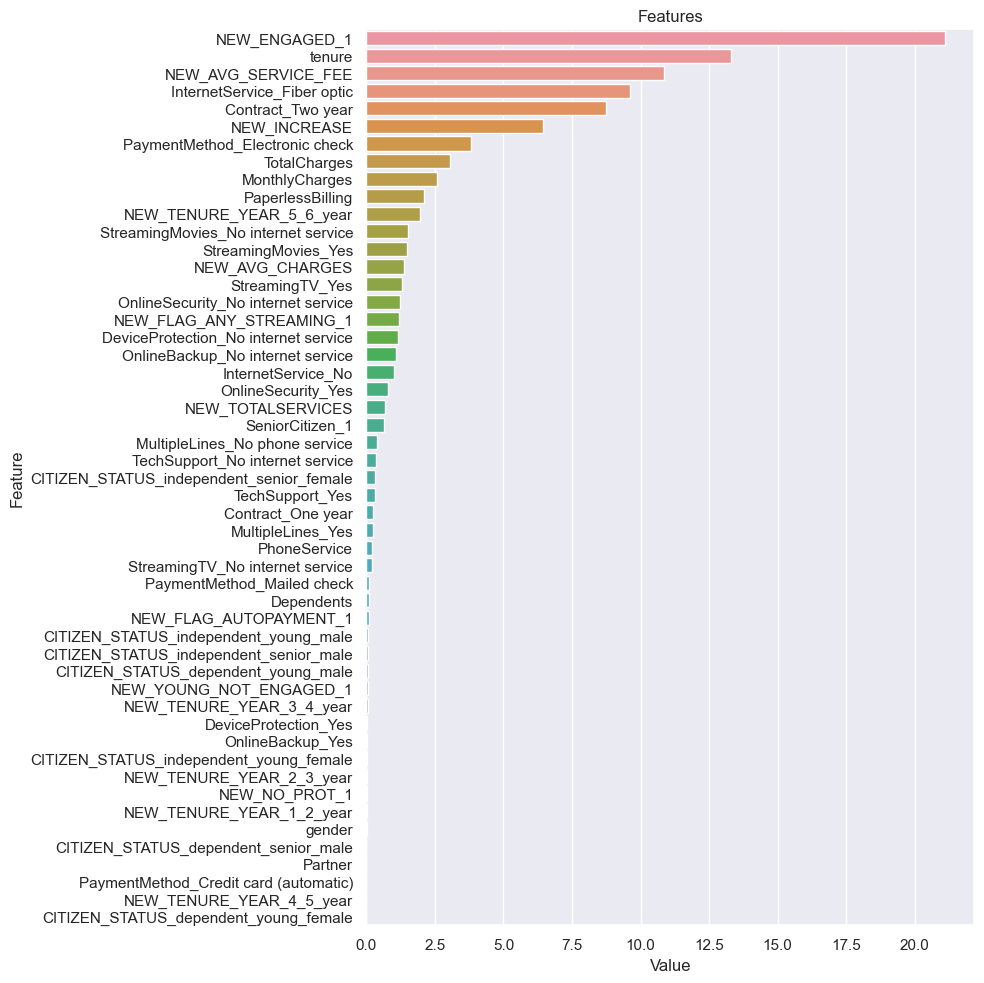

In [84]:
models = [('Random Forest', rf_final), ('XGBoost', xgboost_final), ('LightGBM', lgbm_final), ('CatBoost', catboost_final)]

for model_name, model in models:
    print(f'Feature Importance for {model_name}:')
    plot_importance(model, X)